<a href="https://colab.research.google.com/github/silo86/sign_language_classifier/blob/main/sign_language_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import csv
import tensorflow as tf
from matplotlib import pyplot as plt
#from tensorflow.keras import layers
#from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls drive/MyDrive/Colab\ Notebooks/Kaggle\ practice/Sign\ MNIST

 american_sign_language.PNG   archive.zip         sign_mnist_test.csv
 amer_sign2.png              'sign MNIST.ipynb'   sign_mnist_train/
 amer_sign3.png               sign_mnist_test/    sign_mnist_train.csv


In [ ]:
zip_path = 'drive/MyDrive/Colab Notebooks/Kaggle practice/Sign MNIST'
zip_ref = zipfile.ZipFile(os.path.join(zip_path,'archive.zip'), 'r')
zip_ref.extractall(zip_path)
zip_ref.close()

In [ ]:
os.chdir(zip_path)

In [ ]:
cwd = os.getcwd()

In [ ]:
%ls 

 american_sign_language.PNG   archive.zip         sign_mnist_test.csv
 amer_sign2.png              'sign MNIST.ipynb'   sign_mnist_train/
 amer_sign3.png               sign_mnist_test/    sign_mnist_train.csv


In [ ]:
train = os.path.join(cwd,'sign_mnist_train')
test = os.path.join(cwd,'sign_mnist_test')

In [ ]:
train_data = pd.read_csv(os.path.join(train,'sign_mnist_train.csv'))
test_data = pd.read_csv(os.path.join(test,'sign_mnist_test.csv'))
y_train = train_data['label']
y_test = test_data['label']
print(train_data.shape, test_data.shape)
train_data.drop('label', axis = 1, inplace = True)
test_data.drop('label', axis = 1, inplace = True)
print(train_data.shape,test_data.shape)

(27455, 785) (7172, 785)
(27455, 784) (7172, 784)


In [ ]:
x_train = train_data.values.reshape(train_data.shape[0],28,28)
x_test = test_data.values.reshape(test_data.shape[0],28,28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

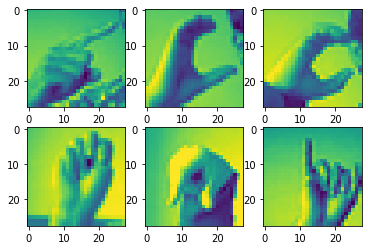

In [ ]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(x_train[i+1])

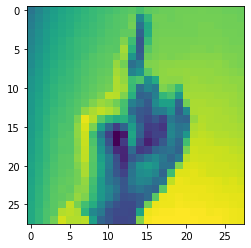

In [ ]:
plt.imshow(x_train[0])

In [ ]:
#you need to add another dimension to the data
x_train = train_data.values.reshape(train_data.shape[0],28,28,1)
x_test = test_data.values.reshape(test_data.shape[0],28,28,1)
print(x_train.shape,x_test.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                    rotation_range=40,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range=0.2,
                                    shear_range=0.2,
                                    horizontal_flip = True,
                                    fill_mode='nearest'
                                    
)
validation_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
train_generator= train_datagen.flow(x_train,
                                    y_train,
                                    batch_size=32
    
)
validation_generator= validation_datagen.flow(x_test,
                                    y_test,
                                    batch_size=32
    
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if logs.get('acc')>0.98:
      print('reached 98% accuracy, stop training')
      self.model.stop_training=True
callbacks=myCallback()

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="Sign_language_detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max',patience=3)
callbacks = [checkpoint]

In [ ]:
model=tf.keras.Sequential([
                      tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1)),
                      tf.keras.layers.MaxPooling2D(2,2),
                      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                      tf.keras.layers.MaxPooling2D(2,2),
                      tf.keras.layers.Dropout(0.25),
                      tf.keras.layers.Flatten(),
                      tf.keras.layers.Dense(512,activation='relu'),
                      tf.keras.layers.Dropout(0.25),
                      tf.keras.layers.Dense(26,activation='softmax')

]
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

In [ ]:
model.compile(
               optimizer='rmsprop',
               loss='sparse_categorical_crossentropy',
               metrics= ['acc']
)

In [ ]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_6_input')>

In [ ]:
%%time
history = model.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=x_train.shape[0]/32,
                    validation_steps = x_test.shape[0]/32,
                    validation_data = validation_generator,
                    callbacks=[callbacks]
)

Epoch 1/20
857/857 [==============================] - 63s 66ms/step - loss: 2.7359 - acc: 0.1674 - val_loss: 1.8201 - val_acc: 0.4084
Epoch 2/20
857/857 [==============================] - 57s 66ms/step - loss: 2.0121 - acc: 0.3628 - val_loss: 1.0655 - val_acc: 0.6372
Epoch 3/20
857/857 [==============================] - 57s 66ms/step - loss: 1.6037 - acc: 0.4857 - val_loss: 0.7889 - val_acc: 0.7641
Epoch 4/20
857/857 [==============================] - 56s 65ms/step - loss: 1.3634 - acc: 0.5532 - val_loss: 0.6203 - val_acc: 0.7929
Epoch 5/20
857/857 [==============================] - 56s 65ms/step - loss: 1.2078 - acc: 0.6042 - val_loss: 0.6374 - val_acc: 0.7791
Epoch 6/20
857/857 [==============================] - 54s 63ms/step - loss: 1.0836 - acc: 0.6429 - val_loss: 0.4586 - val_acc: 0.8299
Epoch 7/20
857/857 [==============================] - 55s 64ms/step - loss: 1.0107 - acc: 0.6688 - val_loss: 0.4116 - val_acc: 0.8694
Epoch 8/20
857/857 [==============================] - 54s 63ms

In [ ]:
unicos = y_train.unique()
unicos

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [ ]:
sorted(unicos)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [ ]:
model.evaluate(x_test,y_test,batch_size=32)

In [ ]:
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.title('Training vs validation losses',size='20')
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
plt.plot(history.history['acc'],'r')
plt.plot(history.history['val_acc'],'b')
plt.title('Training vs validation accuracy',size='20')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
np.expand_dims(x_train[0], axis=0).shape

In [ ]:
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
def classify(custom_array):
  pred = model.predict(
      np.expand_dims(custom_array, axis=0)
  )
  print(len(pred[0]))
  index = np.argmax(pred)
  return letters[index]

In [ ]:
len(letters)

In [ ]:
y_test[1]

In [ ]:
classify(x_train[4])

In [ ]:
len(x_train[0])

In [ ]:
plt.imshow(x_test[0].reshape(28,28), cmap='gray')